# Polychronization(The role of delays)

    This complete neural network has two input and output layers, with 10 neurons in the input layer and two          neurons in the outer layer. We consider two patterns at different times so that the spike time of the input        layer neurons acts accordingly.
    Now, at certain intervals, we apply one of the patterns. According to the STDP law, we expect each of the          neurons in the output layer to learn one of the time patterns.

    To implement this network, each time one of the neurons in the input layer strikes, we reduce the synaptic        weights by the law of STDP (LTD) and in addition, we apply the effects of the spike of the internal neurons        on the external neurons and each time one of the external neurons spikes, we increase the synaptic weights by the rule of STDP (LTP). Since the synaptic weights of the two external neurons are different from each other,each One learns one of the temporal patterns.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
def neural_network(I_init, gl, Cm, num):
    ######### Constants
    U_rest      =   -0.065                  # restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                      # spiking threshold [U]
    tau =  Cm/gl
    A_plus = 2                            #amplitude parameter A ± ( w ) ,we consider this constant!
    A_neg = -1.5
    tau_plus = 0.005                        #tau for stdp rule
    tau_neg = 0.005

    ######### Setup
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    #Two different time patterns
    tp =[[4,15,4,7,7,10000,10000,10000,10000,10000],[10000,10000,10000,10000,10000,5,10,5,2,2]]
    
    
    # VOLTAGE
    U_inp       =   np.zeros((10,len(time)))   # array for saving Voltage history - input layer
    U_inp[:,0]  =   U_rest                     # set initial to resting potential 
    U_out       =   np.zeros((2,len(time)),dtype = np.float64) #outer layer
    U_out[:,0]  =   U_rest
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((10,len(time)))
    I_out       =   np.zeros((2,len(time)))
    I_out[0,:]  = 0.0003
    I_out[1,:]  = 0.0003
    
    

    ######### Measurements
    spikes = [[0] for i in range(10)]         #save the time of neuron's spike - input layer neurons 
    spikes_out = [[0],[0]]                    #output layer neurons - spike time
    
    delta_W = [[],[]]                         #save the changing of synapse weight [∆ w]
    delta_T = [[],[]]                         #save the |∆ t | = | t-post − t-pre | 
    
    W = np.zeros((10,2))
    W[:,0] = abs(np.random.normal(3,1,size=(10)))/3 #set weights for the connection
    W[:,1] = abs(np.random.normal(3,1,size=(10)))/7
   
    cnt = 0
    
    ######### Simulation
    for i in range(1,len(time)):
        
            
        #cnt = abs(cnt - 1*bool(i% 550 == 0)) 
        if(i%550==0): cnt = randint(0,550)%2
        #input layer neurons
        for j in range(10):
            
            if(i% 550 == 0):  U_inp[j][i-1] = U_rest
            #compute current
            I[j][i]= I[j][i] + (I_init[i]+bool(i%tp[cnt][j] == 0)*0.0027)*bool(tp[cnt][j] != 10000)
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U_inp[j][i] = (((U_rest - U_inp[j][i-1]) + I[j][i]/gl)*dt)/tau + U_inp[j][i-1]
            
            
            # in case we exceed threshold               
            if U_inp[j][i] > thresh :
                
                U_inp[j][i-1] = 0.04         # set the last step to spike value
                U_inp[j][i] = U_reset        # current step is resting membrane potential
            
                spikes[j].append(time[i])    # count spike
                
                for l in range(2):
                    time_diff = spikes[j][-1]-spikes_out[l][-1]
                    if(len(spikes_out[l])!=1 and time_diff>0 and time_diff<time[500]):
                        #use "∆ w − = A − ( w ) · exp(−|∆ t |/τ − ) at t-pre " to get this equation
                        delta_T[l].append((spikes_out[l][-1] - spikes[j][-1]))
                        delta_W[l].append((A_neg*math.exp(-1*abs(delta_T[l][-1])/tau_neg)))
                        if(W[j,l] > abs(delta_W[l][-1])): W[j,l] += delta_W[l][-1]
                    
                if(i< 9996):
                    add_amount = I_values(j,i,I_init,time,spikes,W)
                    I_out[:,i+1:i+2] = I_out[:,i+1:i+2] + add_amount
                
        #output layer neurons        
        for l in range(2):
            U_out[l,i] = (((U_rest - U_out[l,i-1]) + I_out[l,i]/gl)*dt)/tau + U_out[l,i-1]
            if U_out[l][i] > thresh:
                U_out[l][i-1] = 0.04        # set the last step to spike value
                U_out[l][i] = U_reset       # current step is resting membrane potential 
                spikes_out[l].append(time[i])
                for j in range(10):
                    if(time[i] - spikes[j][-1] >0 and time[i] - spikes[j][-1]<time[300] ):
                        #use  "∆ w + = A + ( w ) · exp(−|∆ t |/τ + ) at t-post" to get this equation
                        delta_T[l].append((time[i] - spikes[j][-1]))
                        delta_W[l].append((A_plus*math.exp(-1*abs(delta_T[l][-1])/tau_plus)))
                        W[j,l] += delta_W[l][-1]    
                            
    return delta_W, delta_T, spikes, U_out, W

#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:10000] = I_init
    return I0


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,tau_I=0.001):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1= (time[i+1:i+2] - spikes[j][-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp = np.dot(W[j,:].reshape(2,1),exp3.reshape(1,1))
    return I_inp

    

In [3]:
def simul_STDP(I_init ,gl_init ,Cm_init, num):
    
    # TIME
    T       =   0.200                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    
    delta_W, delta_T, spike, U_out, W= neural_network(I_init, gl_init, Cm_init, num)
    delta_W = np.array(delta_W)
    delta_T = np.array(delta_T) 
    zero_t = np.zeros(len(delta_T))
    zero_w = np.zeros(len(delta_W))
    final = len(delta_W)
    for i in range(len(spike)): spike[i].pop(0)
    
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("input layer neurons", figsize=(14, 4))
    colors1 = ['C{}'.format(i) for i in range(10)]
    plt.title("spike raster plot")
    plt.eventplot(spike, color=colors1)
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    
    fig = plt.figure("Potential U for output layer neurons", figsize=(14, 6))
    plt.title("Potential U for output layer neurons")
    plt.plot(time, U_out[0][:], label="Potential:U")[0]
    plt.plot(time, U_out[1][:], label="Potential:U")[0]
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("Population activity of neurons", figsize=(24, 8))
    plt.title("∆t = t-post − t-pre")
    plt.subplot(121)
    plt.scatter(delta_T[0],delta_W[0], marker='o', s=10, c='blue',label="neuron1")
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    plt.subplot(122)
    plt.scatter(delta_T[1],delta_W[1], marker='o', s=10, c='magenta',label="neuron2")
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    print("weights:\n",W)

    
    


weights:
 [[ 7.3898406   0.50642672]
 [ 2.34778448  0.70933212]
 [ 7.3233823   0.48689253]
 [ 1.87465893  0.36551958]
 [ 1.93329619  0.43535042]
 [ 0.50311667 21.45642917]
 [ 0.43950469 21.36216628]
 [ 0.36172504  2.64471814]
 [ 0.26997969  2.66631571]
 [ 0.49343335  4.13968965]]


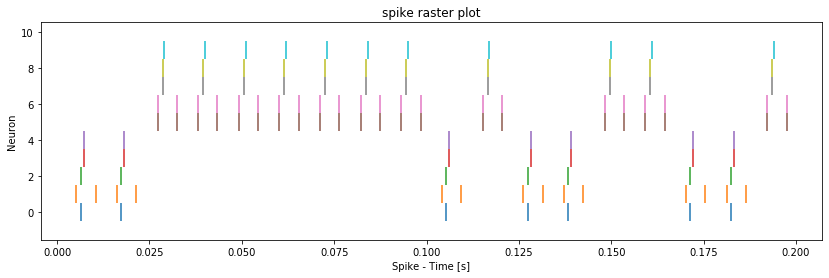

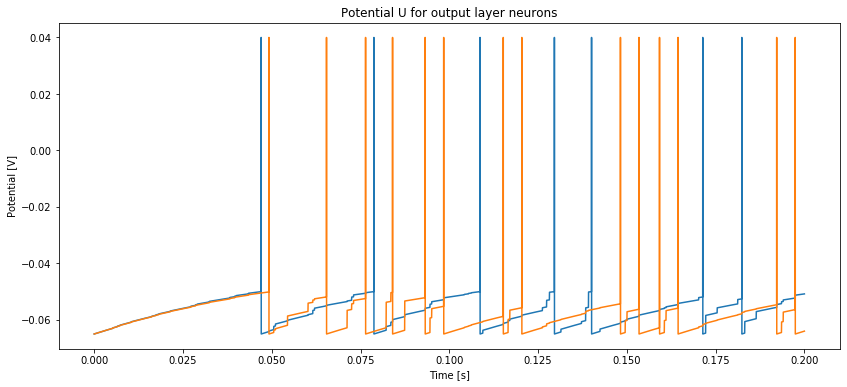

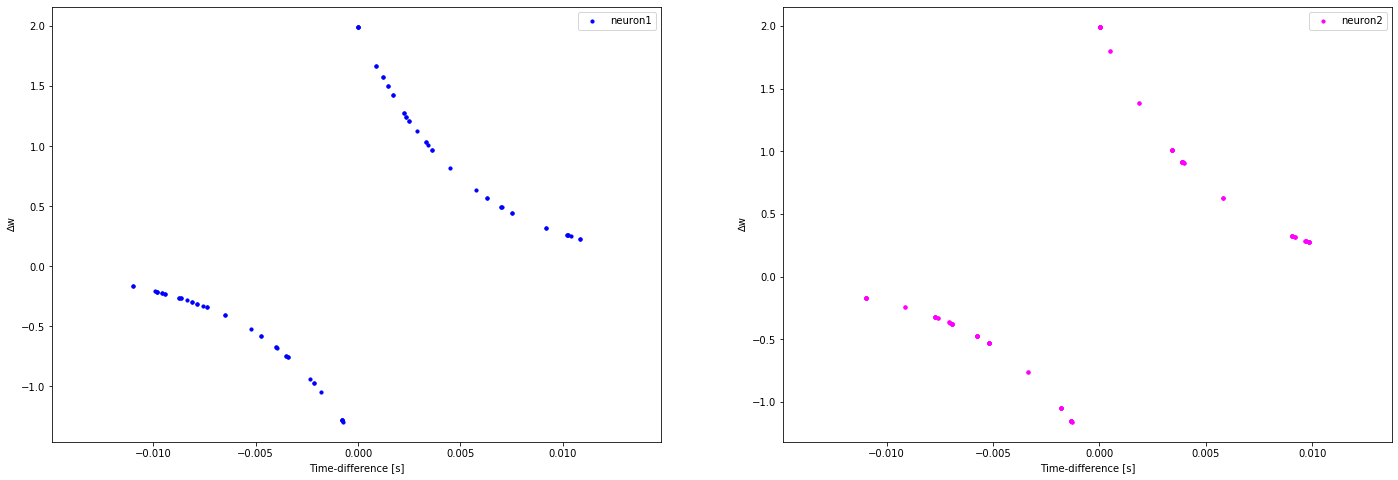

In [196]:
simul_STDP(0.002 ,0.016,0.001 ,1)

weights:
 [[ 0.32633575  2.29420316]
 [ 0.02659993 10.16044491]
 [ 0.40503368  2.19577203]
 [ 0.27399017 11.67531094]
 [ 0.32992789 11.80453933]
 [10.63136242  0.48340158]
 [10.47411366  0.54500804]
 [ 0.81187958  0.58640178]
 [ 0.8311287   0.49539761]
 [ 9.00708751  0.96001564]]


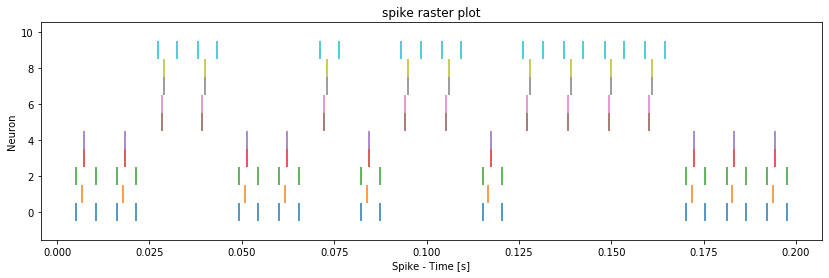

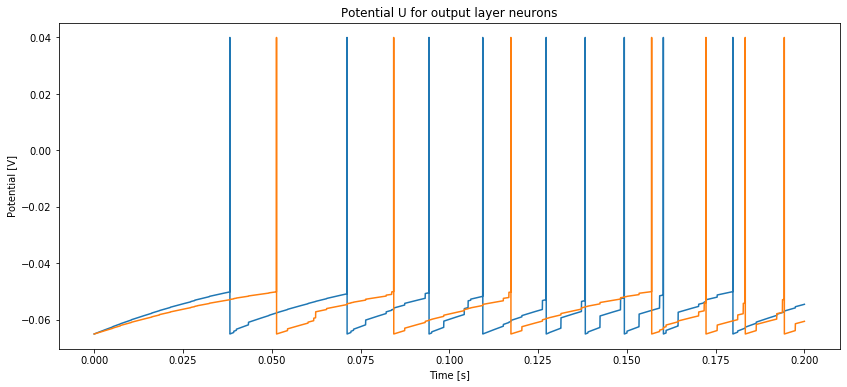

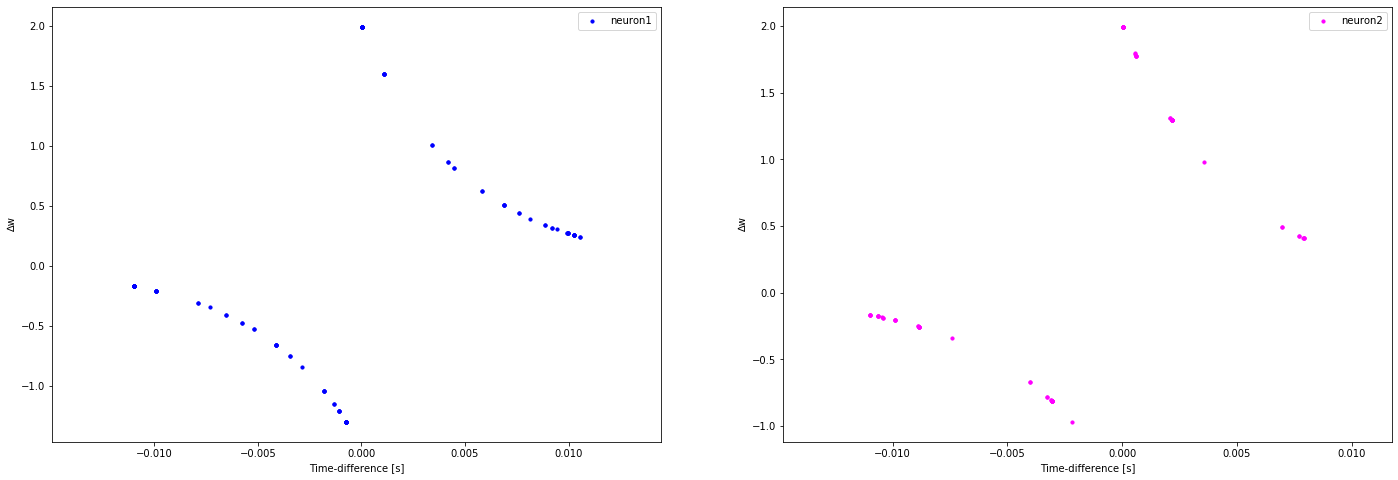

In [519]:
simul_STDP(0.002 ,0.016,0.001 ,1)

weights:
 [[1.48733204 2.34833272]
 [2.95928259 4.31897712]
 [1.48848455 2.30041885]
 [3.58266468 5.30325097]
 [3.59113122 5.05726464]
 [4.94398999 0.10869719]
 [4.9770052  0.09483505]
 [3.05919824 0.19726758]
 [3.12447357 0.18042487]
 [1.42592716 1.24483571]]


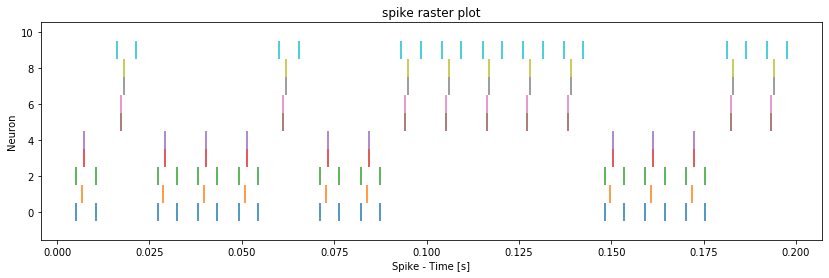

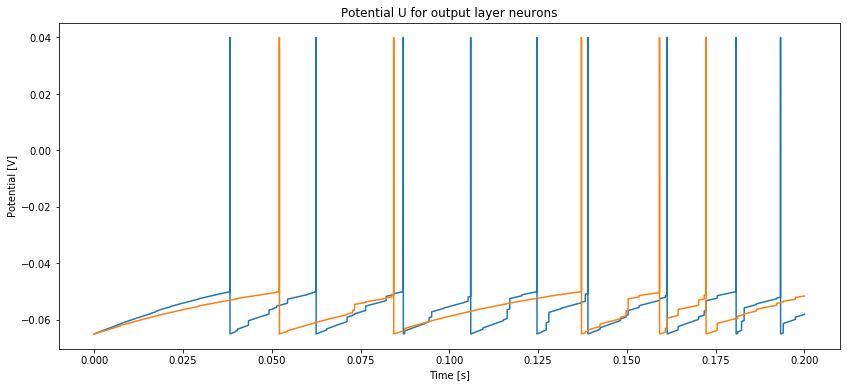

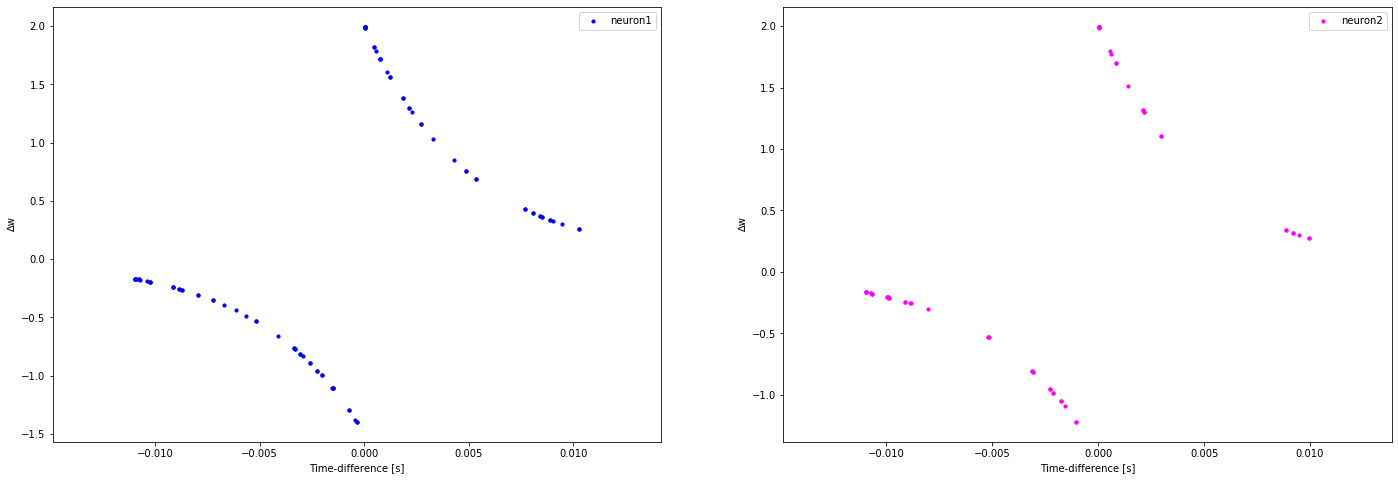

In [514]:
simul_STDP(0.002,0.016,0.001 ,1)

weights:
 [[15.66079185  2.94451277]
 [ 1.61767331  3.16042163]
 [15.63073491  2.82802304]
 [ 2.63270242  0.4707626 ]
 [ 2.72161742  0.63377555]
 [ 0.97167294  9.69837242]
 [ 0.90682147  9.66007985]
 [ 0.73430632  1.38928189]
 [ 0.94128082  1.43638238]
 [ 0.71356053  1.72536255]]


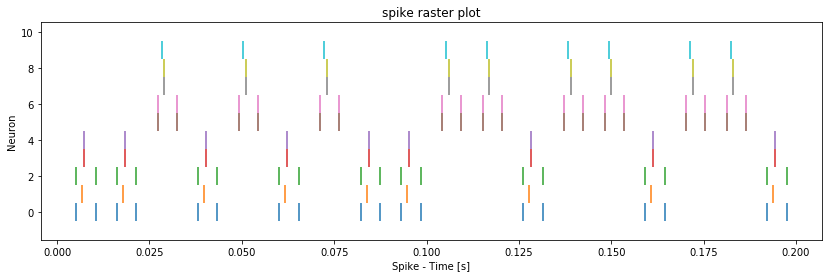

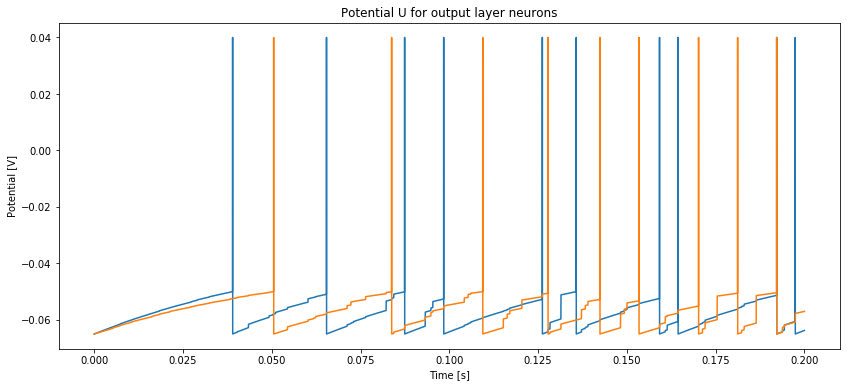

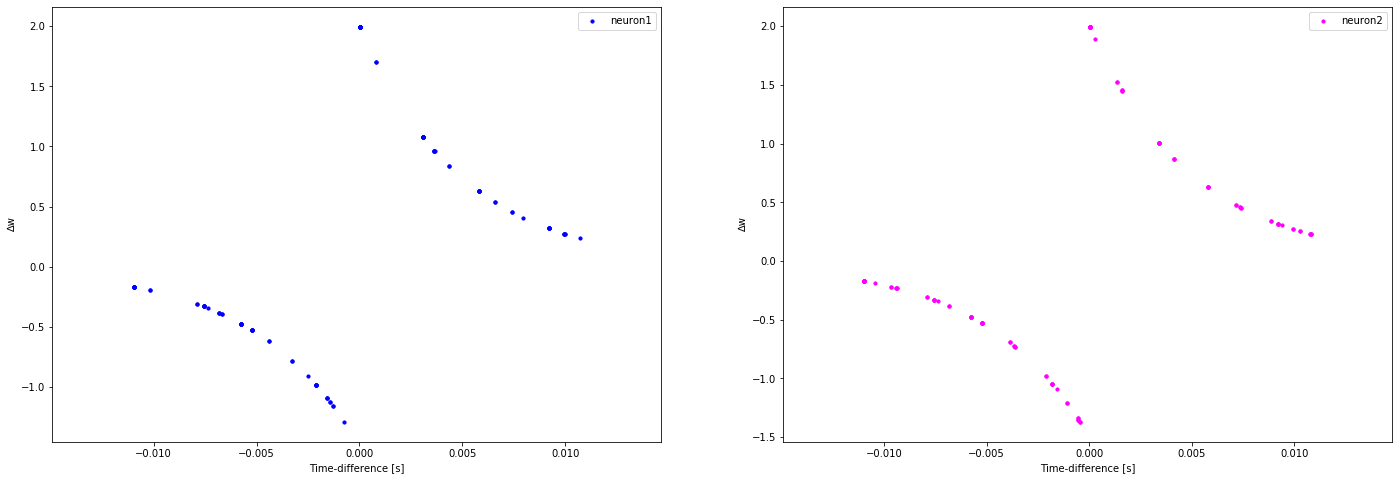

In [524]:
simul_STDP(0.002,0.016,0.001 ,1)

weights:
 [[10.07345887  0.59244954]
 [ 3.71380249  0.84778147]
 [ 9.95158749  0.62903956]
 [ 4.19070571  0.866709  ]
 [ 4.19286721  0.91947612]
 [ 0.50653199  1.92302717]
 [ 0.42884099  1.9417167 ]
 [ 0.11747512  8.71455211]
 [ 0.03140406  8.7860625 ]
 [ 0.02192603  7.56028312]]


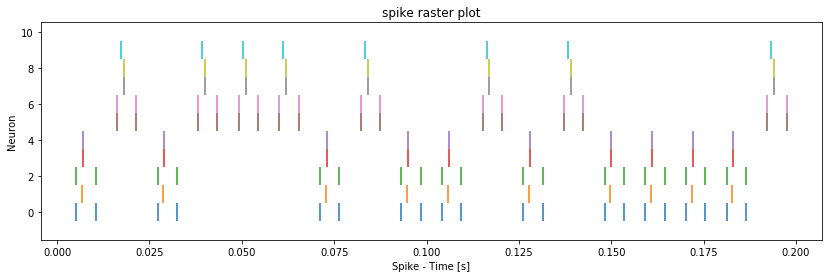

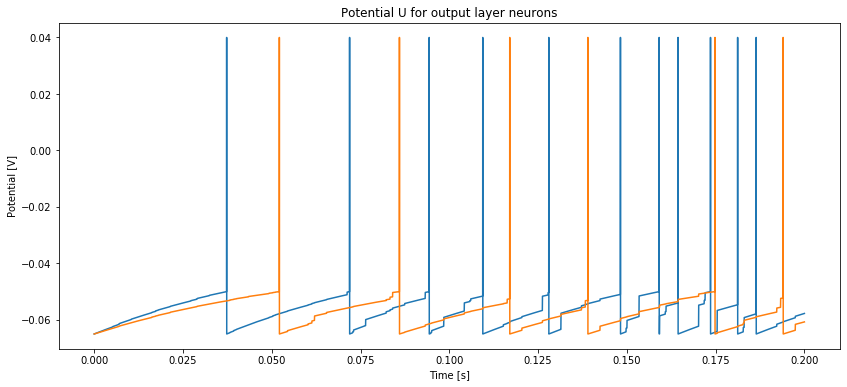

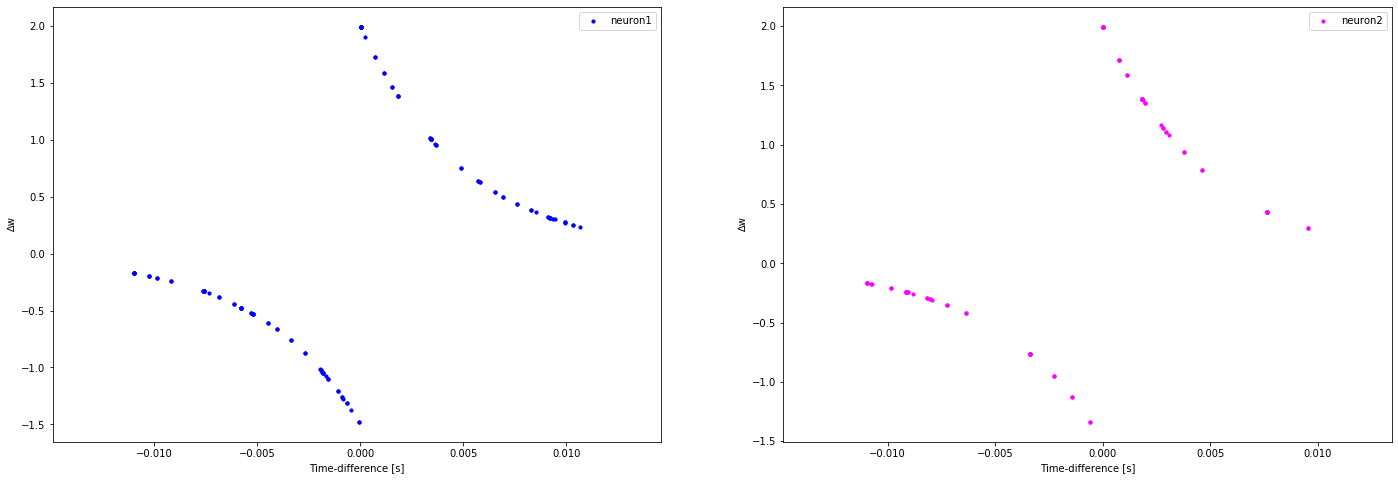

In [528]:
simul_STDP(0.002,0.016,0.001 ,1)

weights:
 [[0.72872372 3.59146372]
 [0.58981045 1.35016404]
 [0.74729551 3.56940594]
 [0.5955425  1.51175013]
 [0.60337356 1.53874564]
 [7.07947147 0.23292235]
 [7.06729276 0.21016769]
 [1.54470658 0.92726512]
 [1.56266654 0.90298703]
 [3.65095186 0.30524432]]


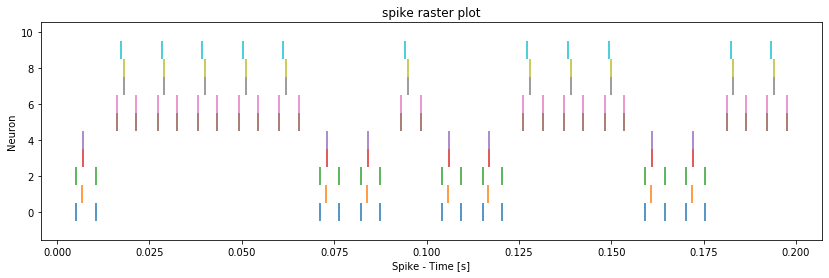

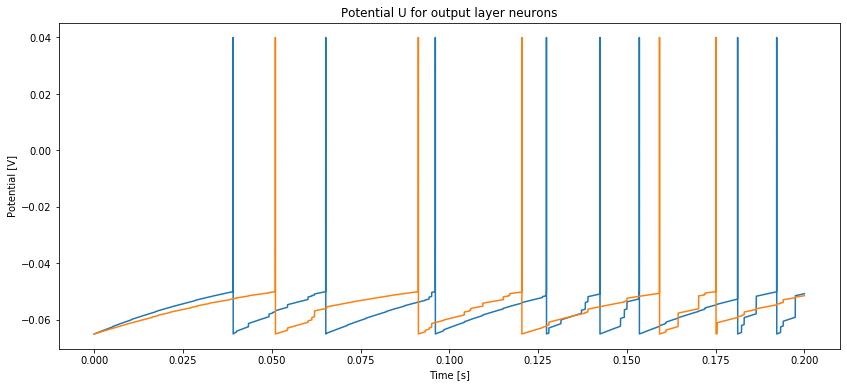

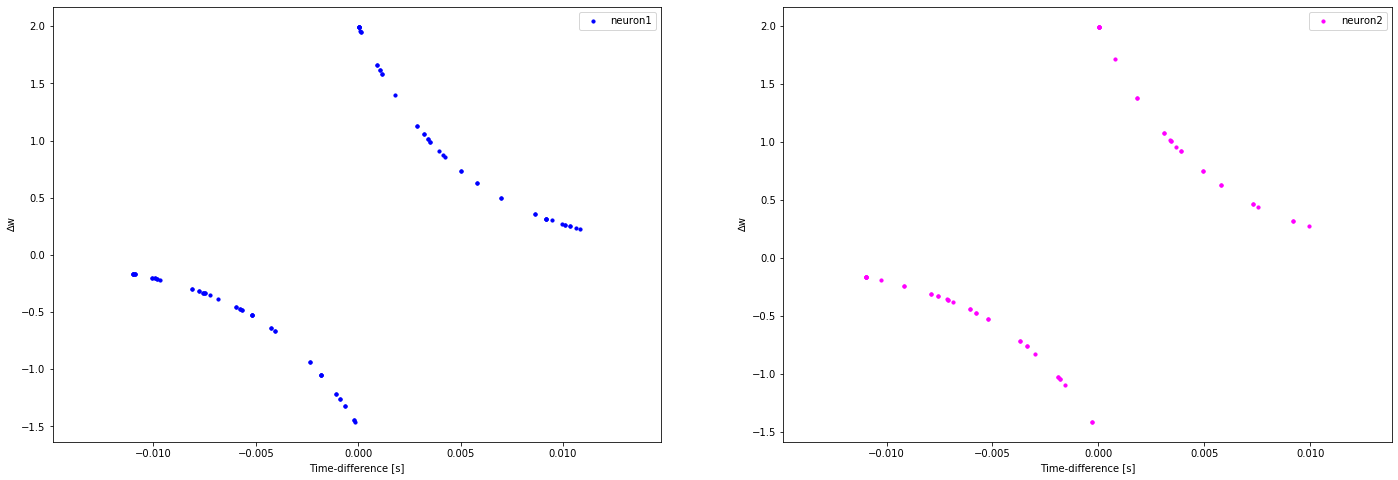

In [596]:
simul_STDP(0.002,0.016,0.001 ,1)

weights:
 [[0.52204543 3.72745135]
 [1.19661845 8.04061885]
 [0.43985317 3.68808779]
 [0.65985068 0.18282227]
 [0.55928572 0.2989145 ]
 [9.02324525 0.92078315]
 [8.95800068 1.02926463]
 [3.58478718 0.58264451]
 [3.64764372 0.47589684]
 [3.71887552 0.29847687]]


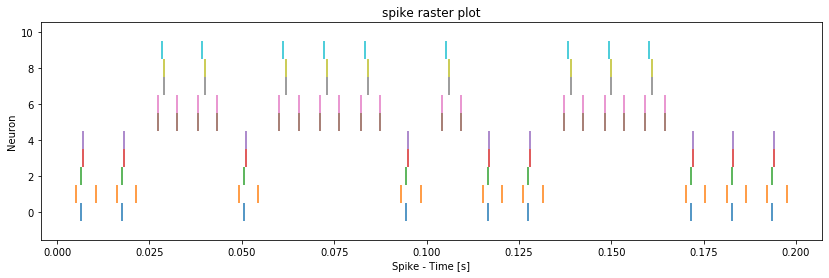

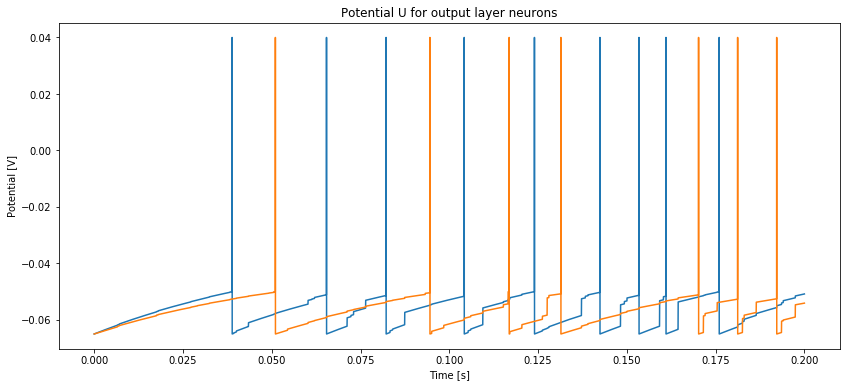

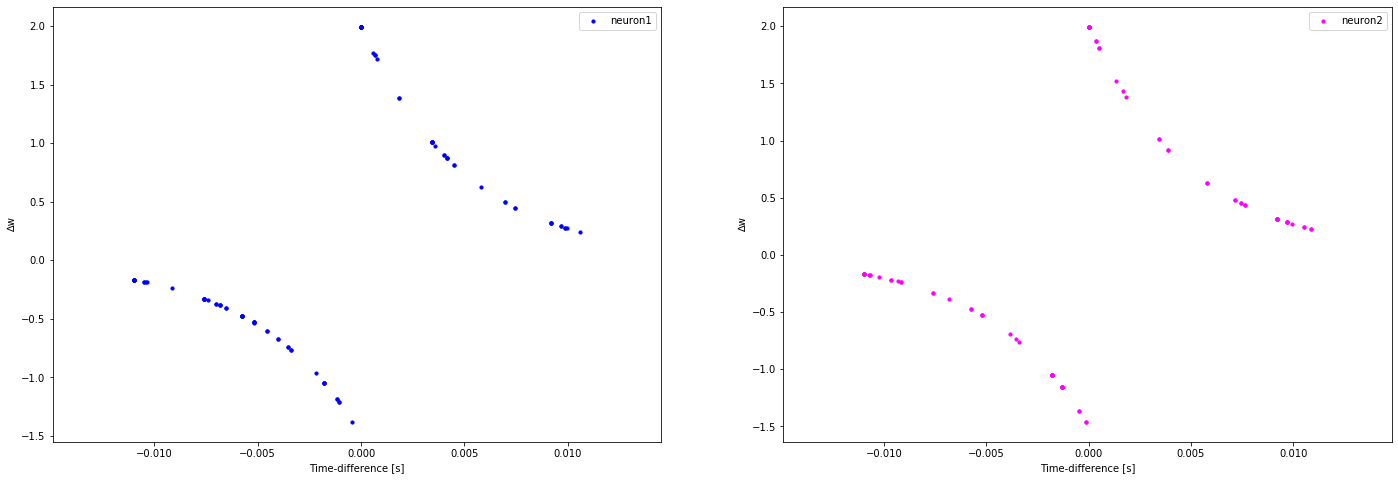

In [716]:
simul_STDP(0.002,0.016,0.001 ,1)

weights:
 [[6.0754834  0.65715035]
 [5.01208725 0.00984746]
 [6.06702155 0.61477199]
 [1.4988028  1.45168758]
 [1.46555569 1.37638355]
 [0.4600847  3.19428775]
 [0.49080644 3.10765765]
 [2.12752589 4.99305939]
 [0.36026393 5.90715153]
 [0.59143768 5.82279318]]


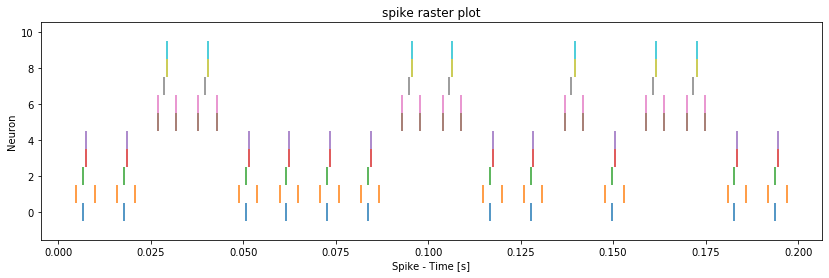

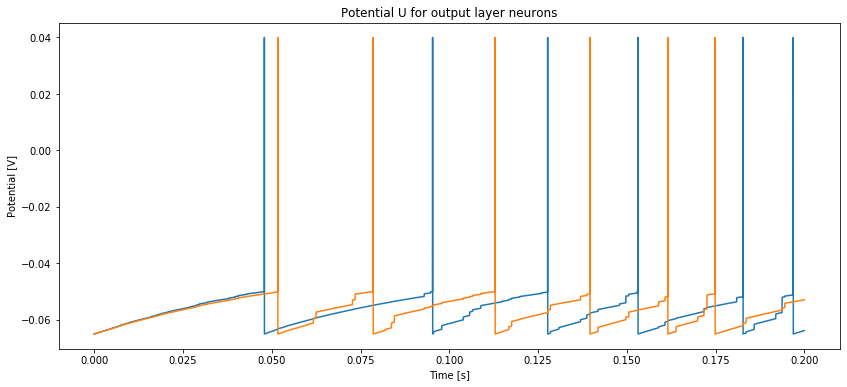

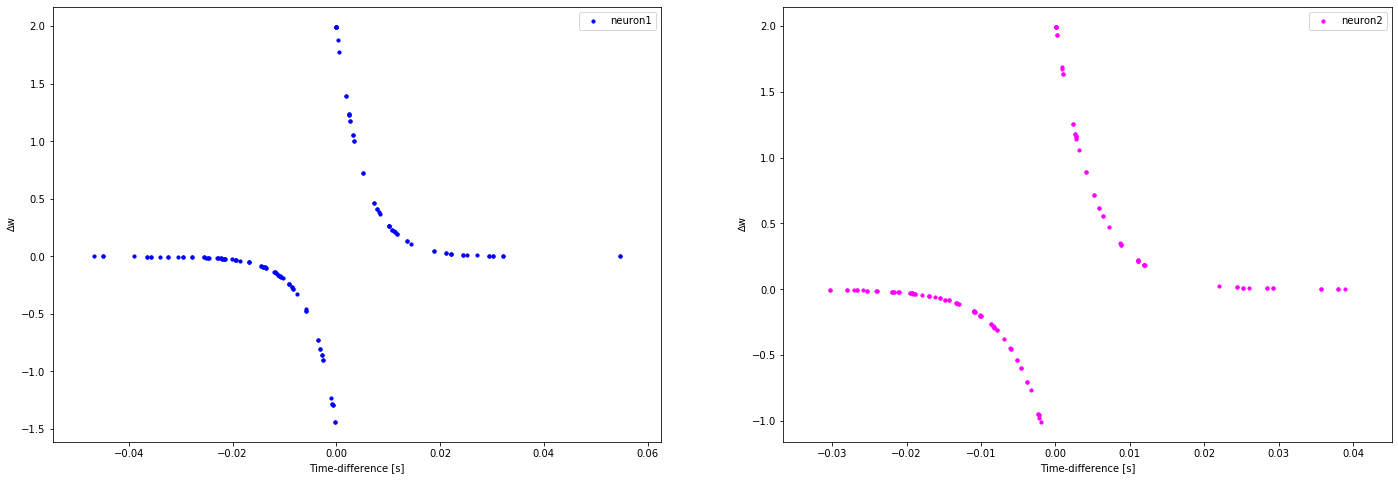

In [899]:
simul_STDP(0.002 ,0.016,0.001 ,1)

weights:
 [[16.13133462  1.48896082]
 [ 0.82646672  0.20627418]
 [16.13133462  1.48896082]
 [ 0.29307785  3.4737981 ]
 [ 0.10737954  3.1737981 ]
 [ 0.81516631 12.2717938 ]
 [ 1.3201218   0.75253331]
 [ 0.81516631 12.5717938 ]
 [ 0.0765829  10.40536201]
 [ 0.1765829  10.60536201]]


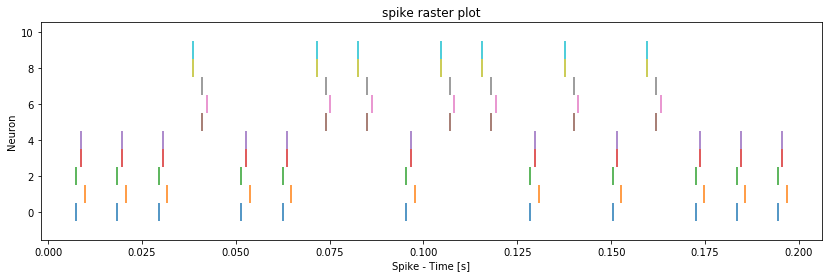

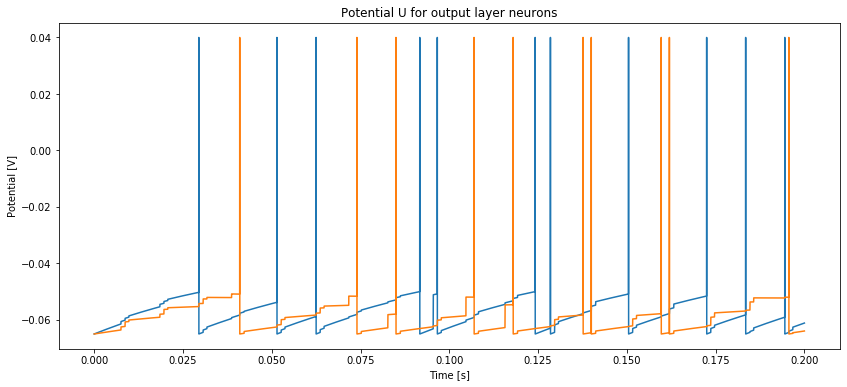

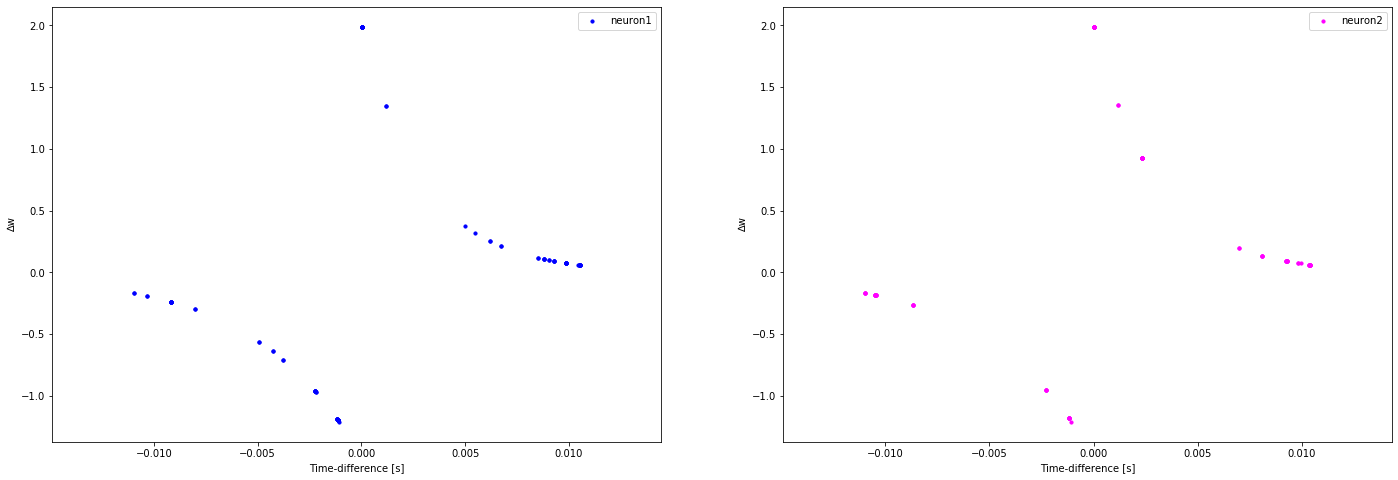

In [1888]:
simul_STDP(0.0015 ,0.016,0.001 ,1)

weights:
 [[ 0.86157339 15.76845805]
 [ 5.64580575 28.30224096]
 [ 0.17014382 15.73128483]
 [ 0.39678032  0.5767719 ]
 [ 0.41246791  0.74035989]
 [ 0.78804051  0.13659   ]
 [ 6.06232072  0.1963913 ]
 [ 0.79581959  0.04713227]
 [ 0.75949559  0.18259457]
 [ 0.12500369  0.08613375]]


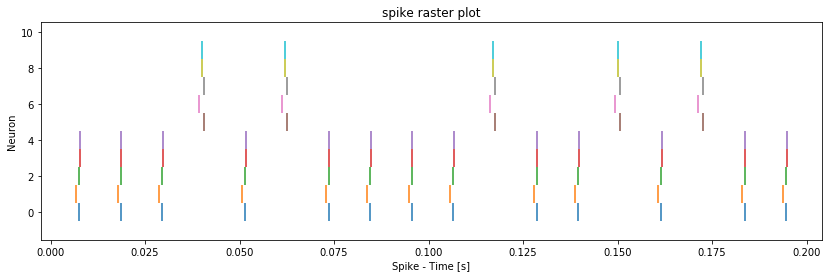

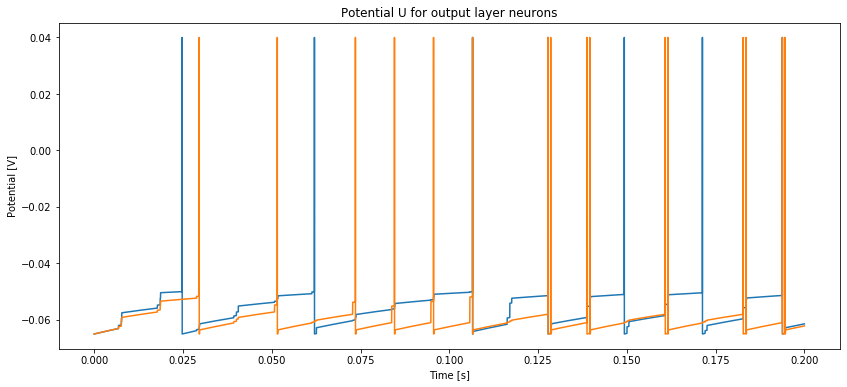

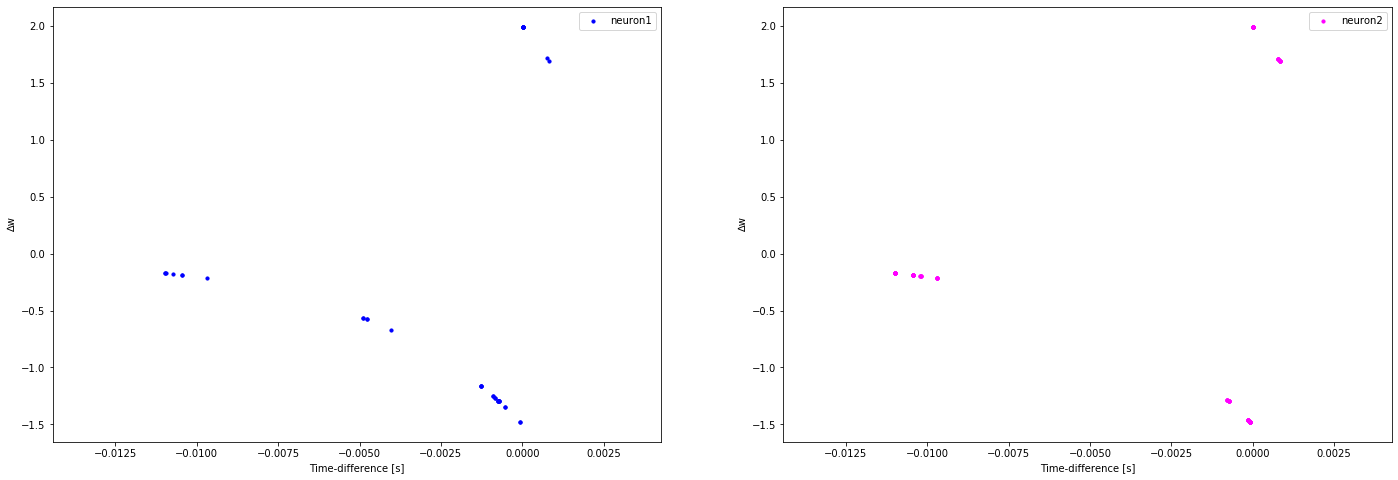

In [125]:
simul_STDP(0.002 ,0.016,0.001 ,1)

weights:
 [[ 0.76305738  0.22142072]
 [13.74500071  0.3581487 ]
 [ 0.8598706   0.38741072]
 [ 0.02853792  0.44074208]
 [ 0.31320989  0.43863525]
 [ 0.4388328   0.59919872]
 [ 0.139846   10.73492435]
 [ 0.44353337  0.65031062]
 [ 0.4982327   9.17511748]
 [ 0.35932089  9.44979265]]


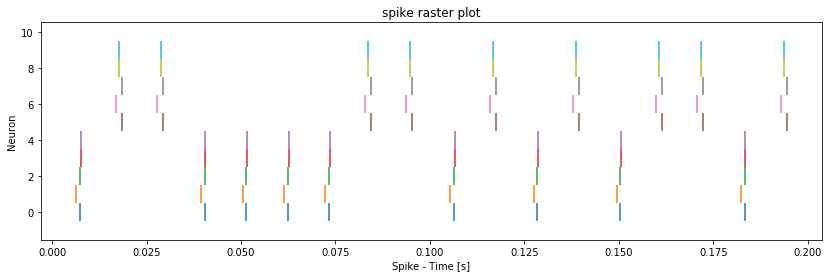

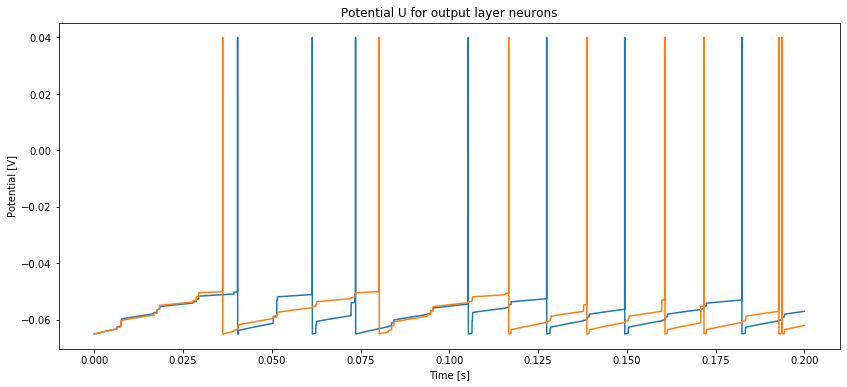

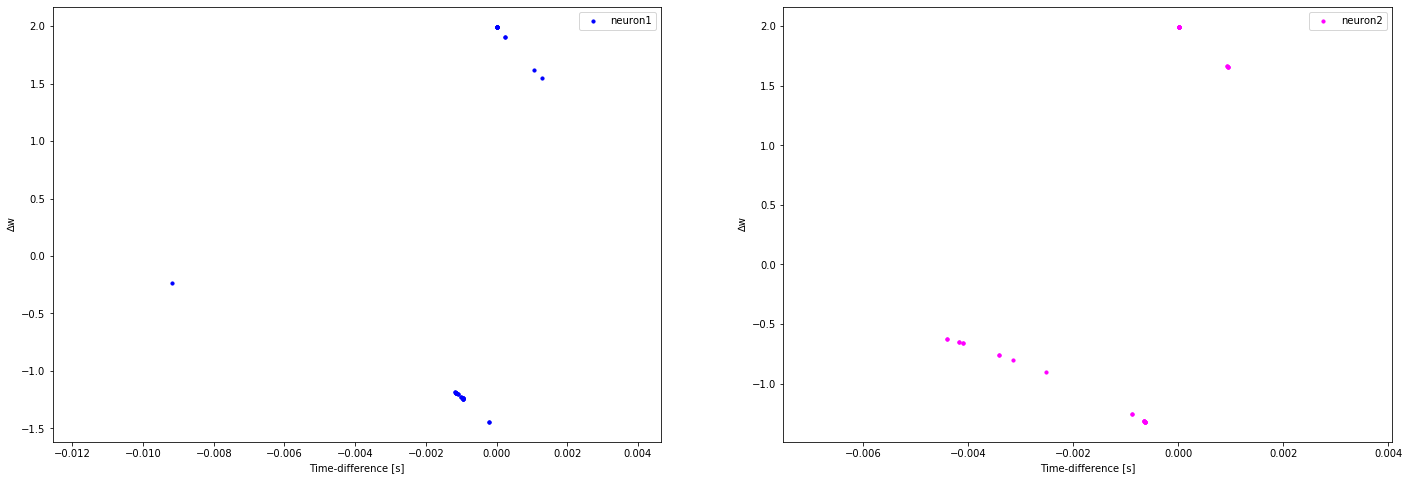

In [143]:
 simul_STDP(0.002 ,0.016,0.001 ,1)       

weights:
 [[4.15096992e-01 8.29574242e+00]
 [2.03059774e+00 9.36935492e+00]
 [2.71365768e-01 8.26218583e+00]
 [6.35361979e-01 2.98976082e+00]
 [4.33035915e-01 3.15260211e+00]
 [1.77572292e-01 2.22960911e-01]
 [1.46740487e+01 1.44047745e-02]
 [1.01223577e+00 5.06263539e-02]
 [2.35597892e+00 1.29375893e-01]
 [1.28195176e+00 6.31668557e-01]]


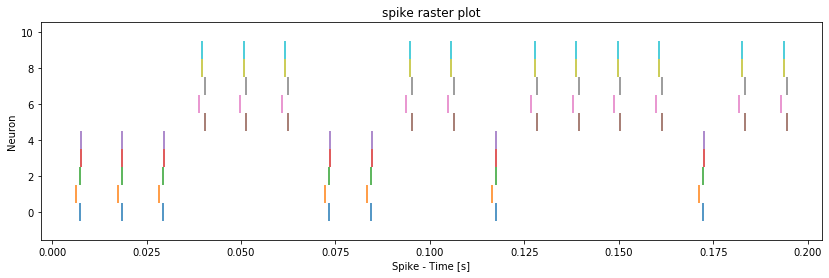

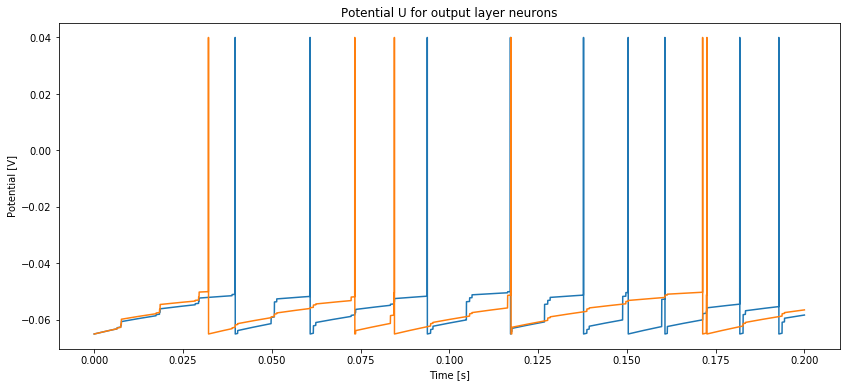

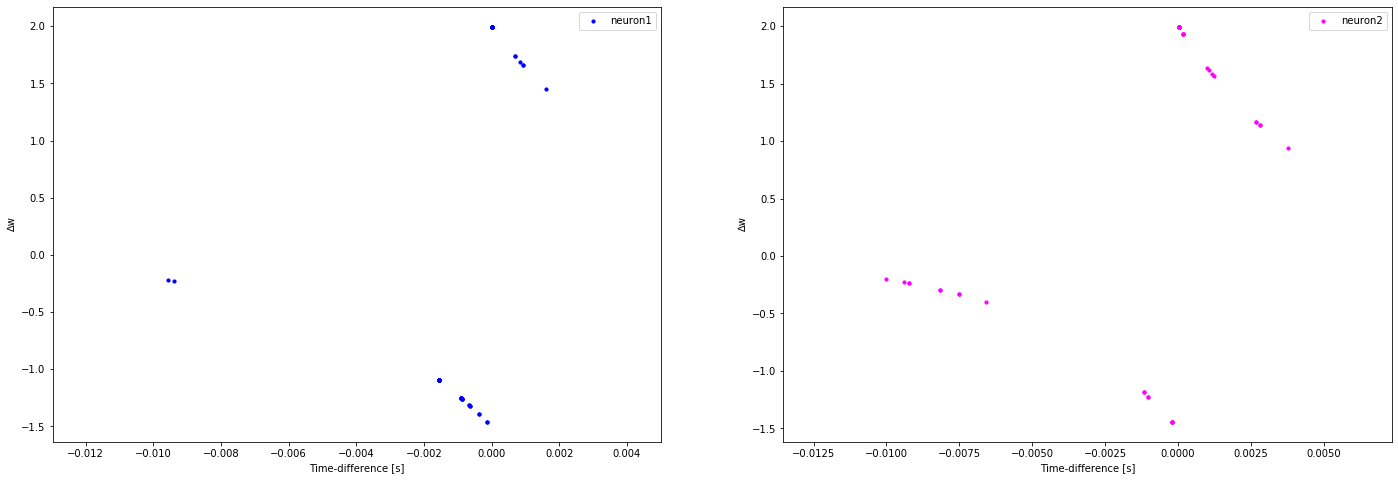

In [153]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[ 5.86871319  2.34123182]
 [ 9.5017584   1.5552447 ]
 [ 5.6659927   2.4574961 ]
 [ 0.4898971   0.43980905]
 [ 0.57544544  0.43847014]
 [ 0.42082191  2.44597152]
 [ 1.69849282 15.51538682]
 [ 0.50994937  2.3571875 ]
 [ 2.63974357  8.32201794]
 [ 2.196308    8.60829877]]


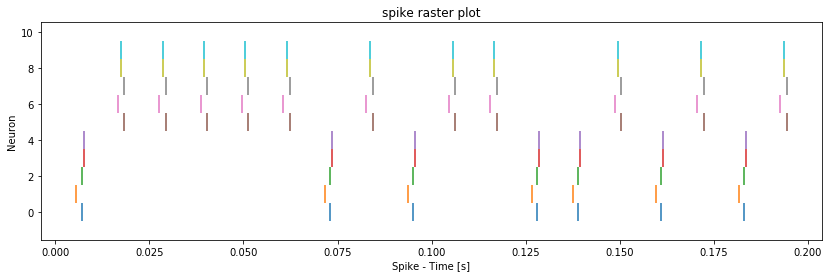

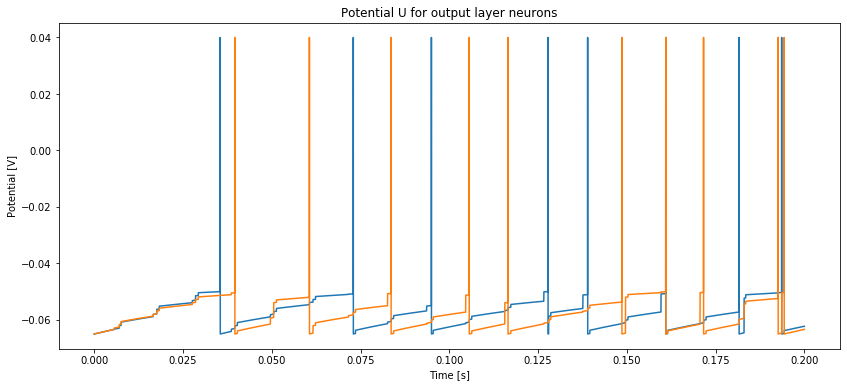

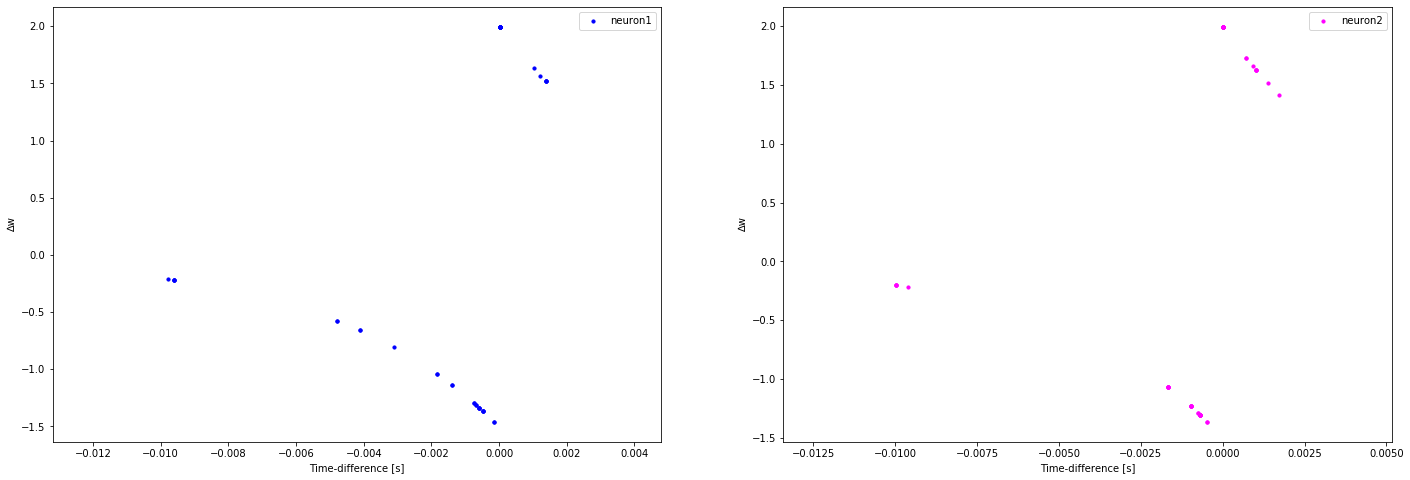

In [180]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[ 1.02555888  0.57453764]
 [13.75640136  0.15339654]
 [ 1.01510926  0.53753109]
 [ 1.00731828  0.33386769]
 [ 0.26078435  0.45651787]
 [ 1.28503612  0.15117159]
 [ 0.6678058  21.80630556]
 [ 1.70071967  0.03064858]
 [ 1.47049526 12.14109983]
 [ 1.40849963 12.34182237]]


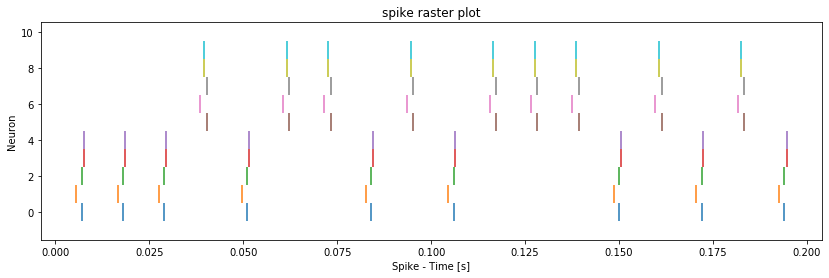

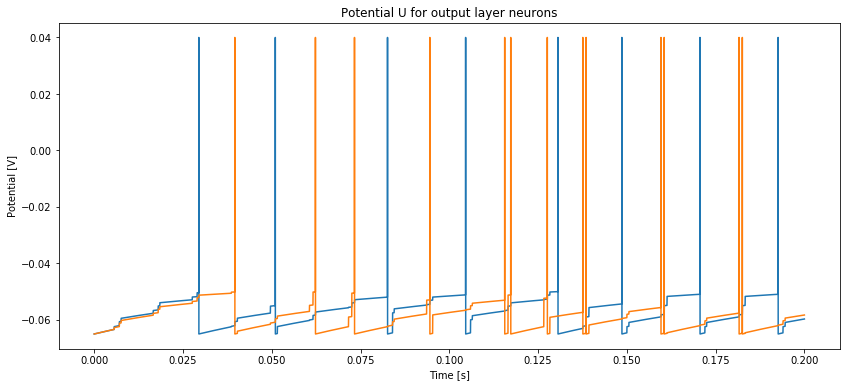

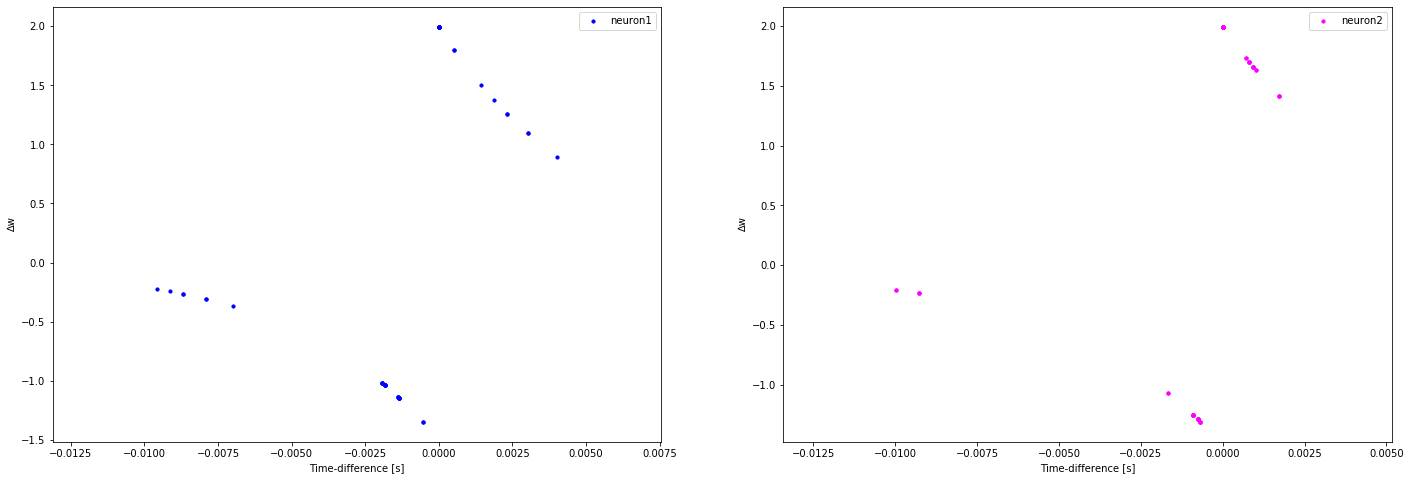

In [186]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[ 0.45614319 14.95669491]
 [ 6.51461423 18.9669692 ]
 [ 0.846128   15.09858881]
 [ 0.29565727  0.38745884]
 [ 0.02865122  0.33767972]
 [ 0.34042214  0.71212859]
 [ 6.69856997  0.18109215]
 [ 0.25208258  0.3803016 ]
 [ 8.08325067  0.44958688]
 [ 8.03656933  0.64713578]]


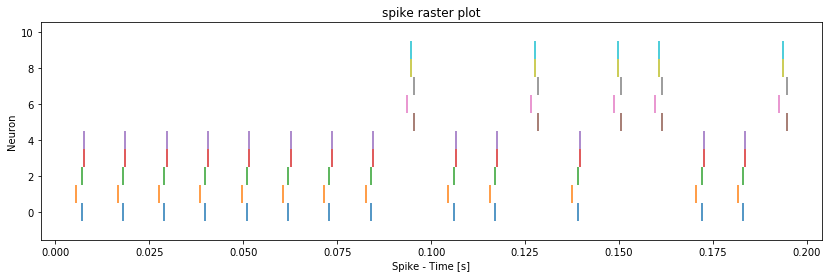

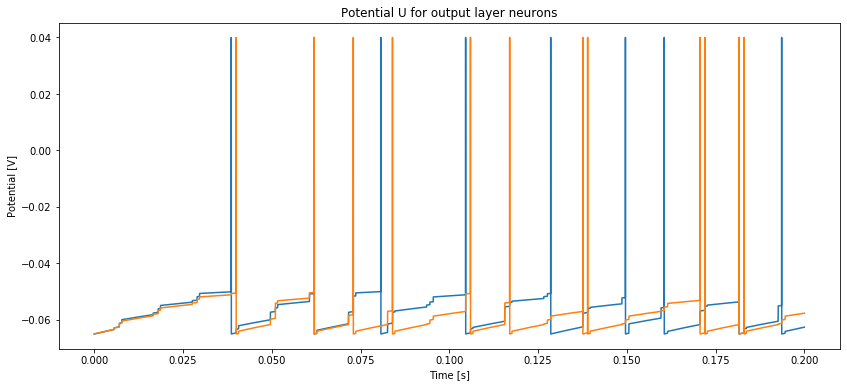

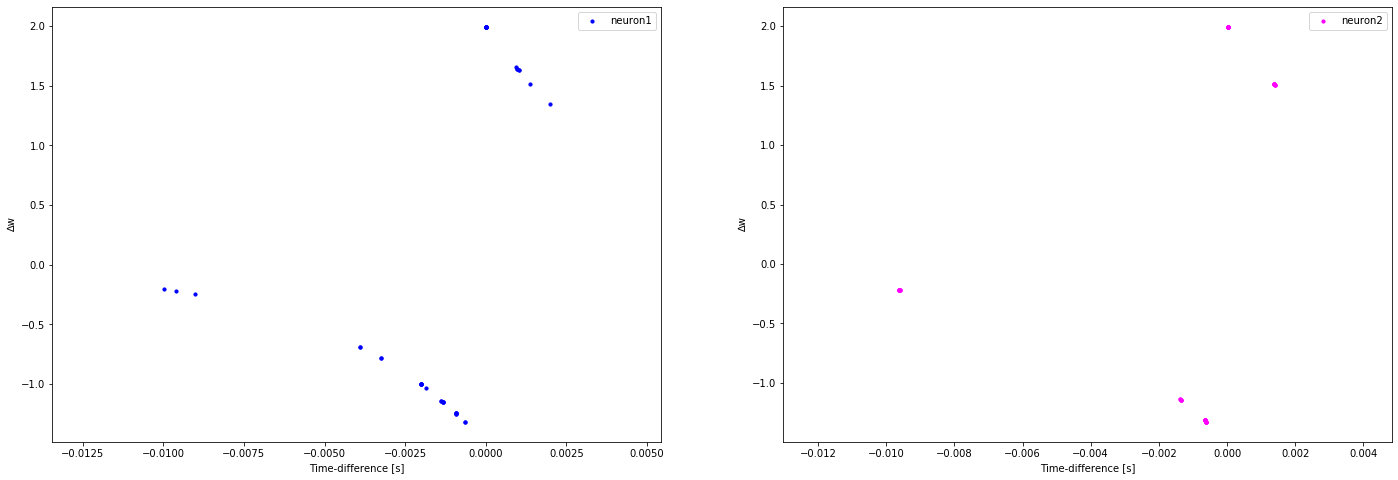

In [191]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[ 4.17237396  0.27835146]
 [10.71609752  0.0604998 ]
 [ 3.93651775  0.50639749]
 [ 0.2296173   0.47218872]
 [ 0.47275513  0.62712799]
 [ 0.7323401   0.20988918]
 [ 0.05005408 19.12075705]
 [ 0.84518667  0.48735452]
 [ 0.11272797 12.49772578]
 [ 0.32076566 12.700165  ]]


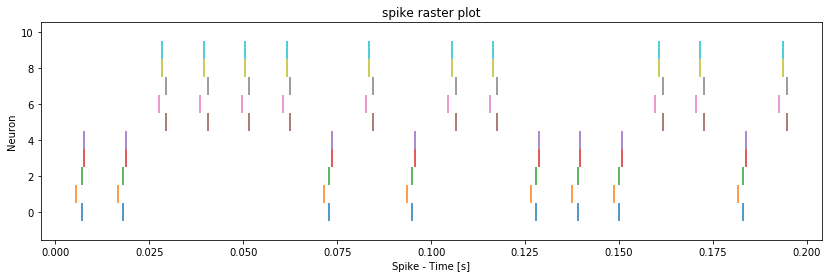

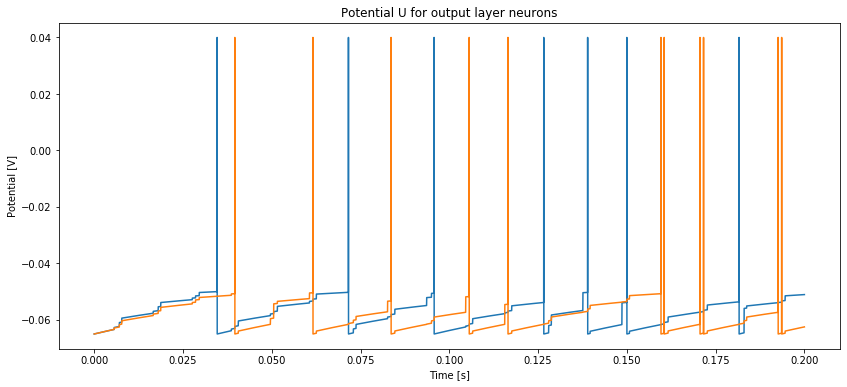

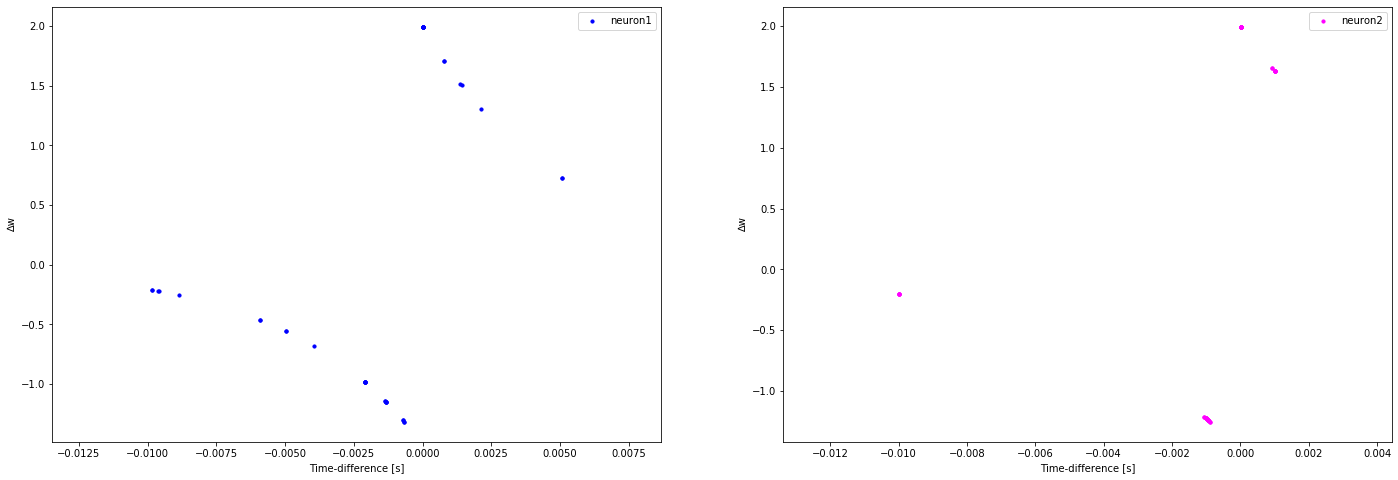

In [210]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[ 0.42420108 12.49041034]
 [ 0.44290115  0.41765882]
 [ 0.17104088 12.56013824]
 [ 0.70714671  0.95662223]
 [ 0.52936389  1.00173768]
 [ 0.82207938  2.45232756]
 [ 0.26595395  0.38534655]
 [ 0.38468936  2.52698429]
 [14.79633752  1.05811585]
 [14.96695287  1.0912086 ]]


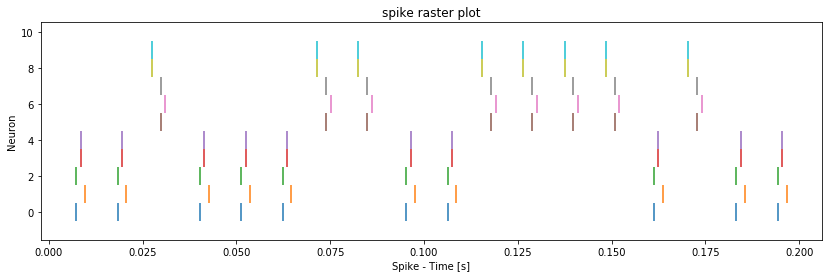

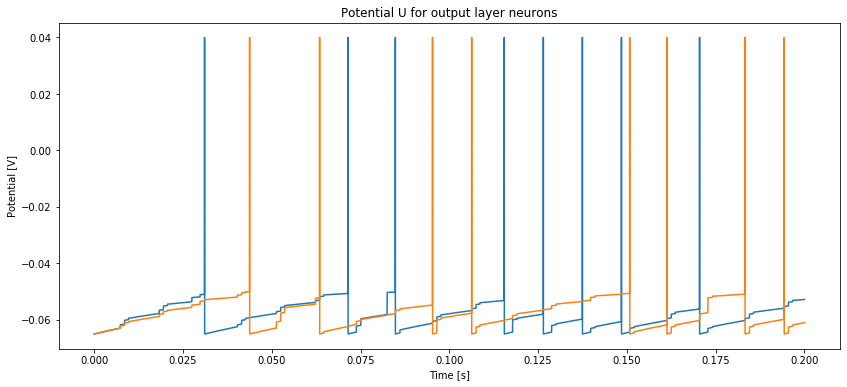

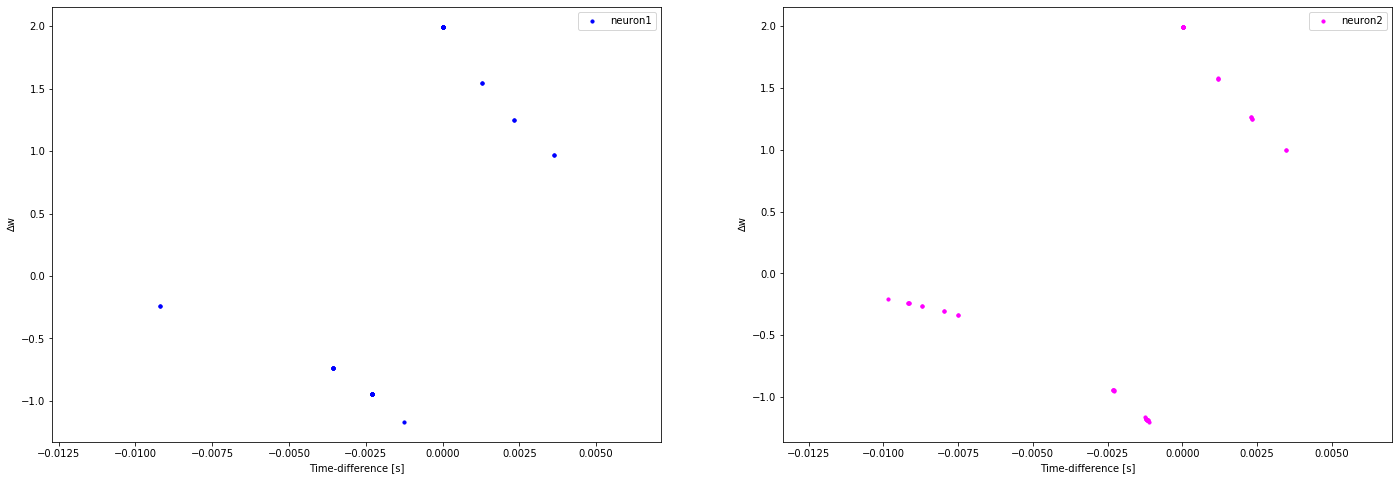

In [212]:
 simul_STDP(0.0015 ,0.016,0.001 ,1) 

weights:
 [[16.86583853 13.73077541]
 [ 0.11037806  0.04320734]
 [16.74634265 13.57816914]
 [ 1.28356432  0.83204901]
 [ 1.14517729  0.86214777]
 [ 3.45507964  0.48941035]
 [ 1.98201655  0.45847283]
 [ 3.04125874  0.60518405]
 [13.27851286  0.06163487]
 [13.11766658  0.07200195]]


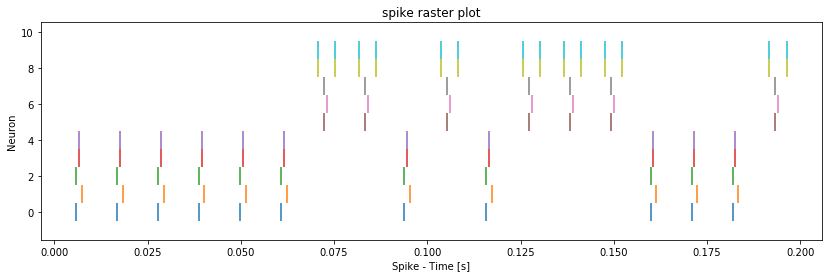

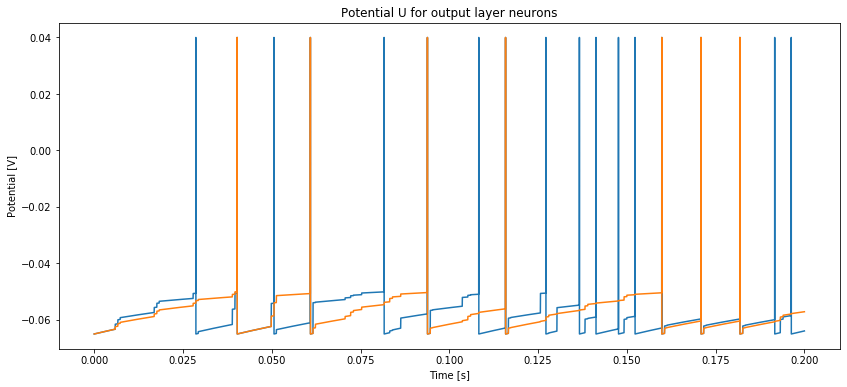

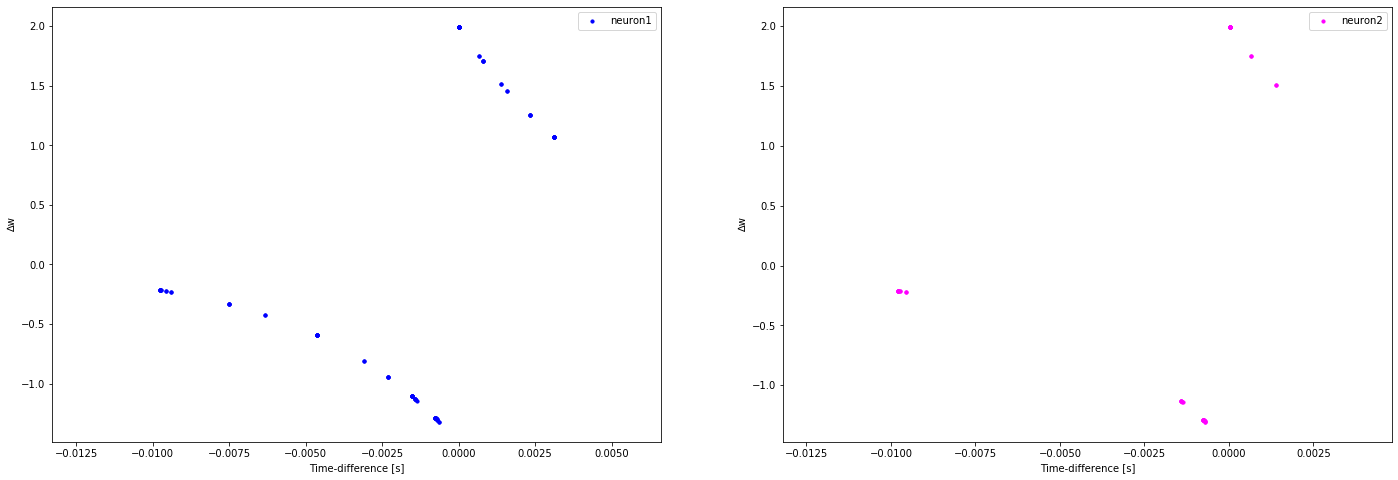

In [213]:
 simul_STDP(0.002 ,0.016,0.001 ,1) 

weights:
 [[17.53400718 14.96887696]
 [ 0.68168558  0.58669117]
 [17.61322959 15.37160239]
 [ 0.68569056  0.83074656]
 [ 0.88284863  0.93868872]
 [12.67231961  0.19036268]
 [ 0.16098577  0.66069981]
 [12.02065711  0.41533862]
 [11.39248137  0.04811949]
 [11.34260049  0.08816096]]


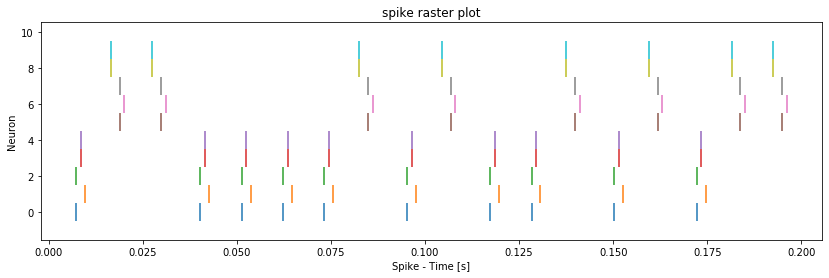

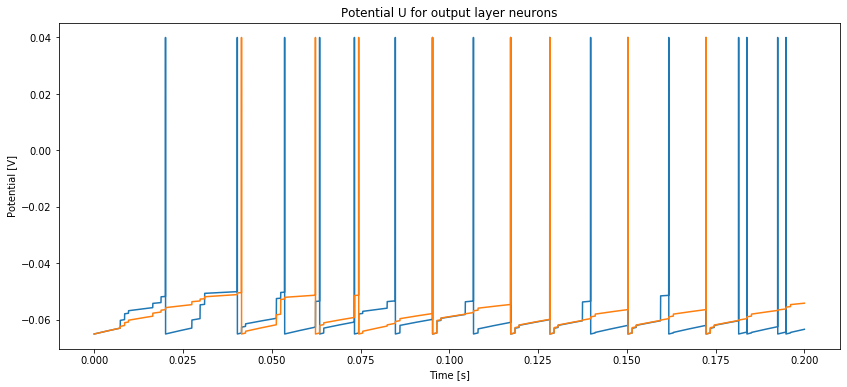

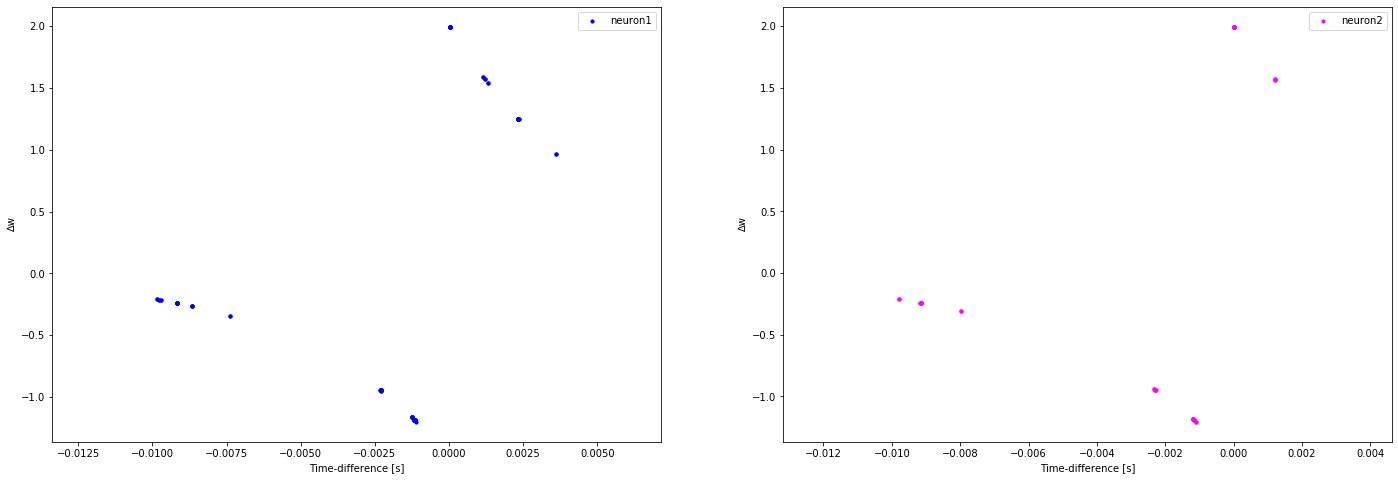

In [236]:
 simul_STDP(0.0015 ,0.016,0.001 ,1) 

weights:
 [[ 8.77144554  0.60547057]
 [ 0.1931731   1.14670241]
 [ 8.68858437  0.59721309]
 [ 0.6141786   0.64432273]
 [ 1.12609717  0.86169661]
 [ 0.91082402  0.78365473]
 [ 0.3556146   0.63489147]
 [ 0.70939375  0.65123962]
 [14.81991193 12.35265523]
 [14.89028015 12.25949537]]


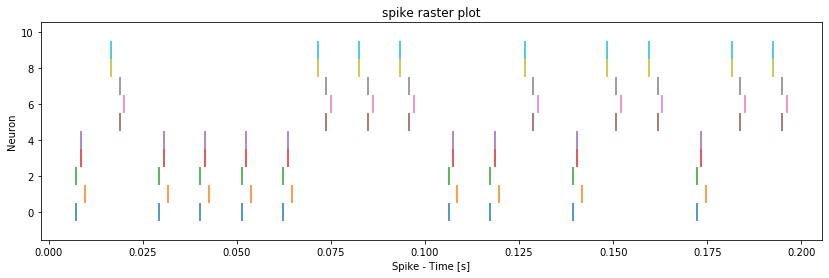

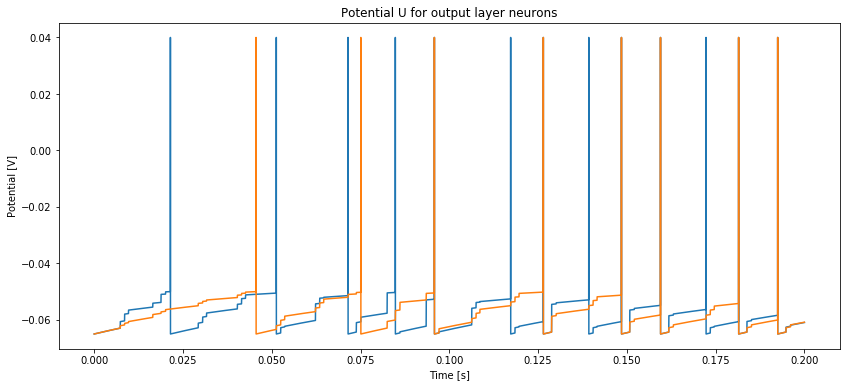

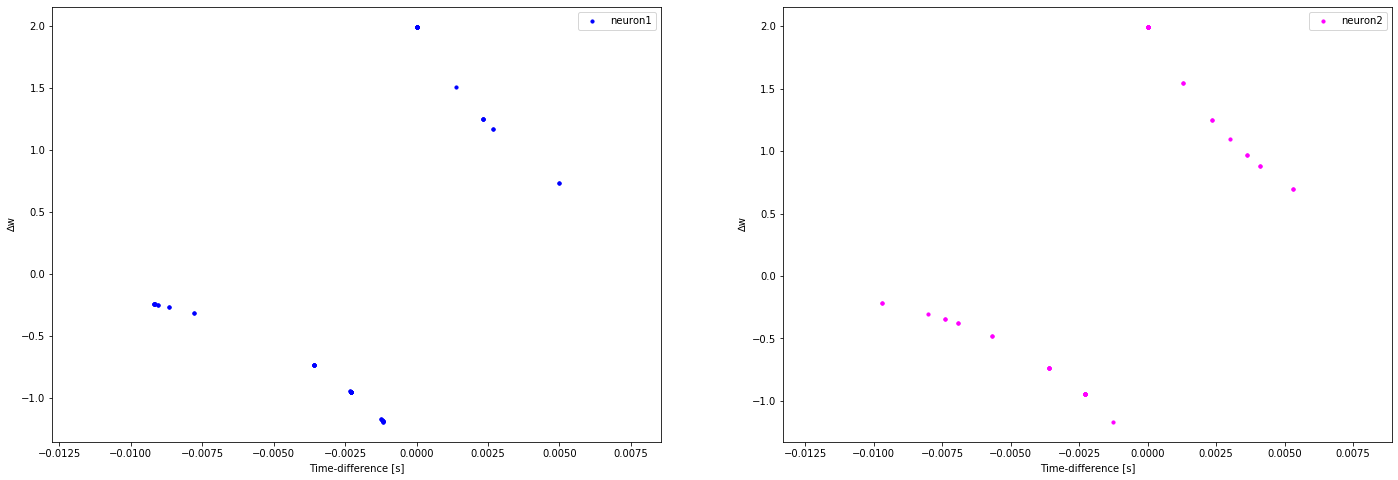

In [7]:
 simul_STDP(0.0015 ,0.016,0.001 ,1) 

######  The effect of each important parameter
    A ± ( w ) : Magnification of weight changes 
    τ         : The effect of time difference of pre- and post-neural spikes
    Synaptic-weights : This simulation works well if the weights of the two output neurons are different enough
    After setting the parameters, this final value seemed appropriate for implementation!
    
Sharare Zolghadr (610395109)                              
Computational Neuroscience    